<a href="https://colab.research.google.com/github/laurelkeys/machine-learning/blob/master/assignment-4/Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies and setup Drive

In [0]:
!pip install PyDrive > /dev/null 2>&1

In [0]:
import os
import zipfile

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from random import randrange

from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

## Download and unzip data

In [0]:
# Enable link sharing for data.zip in your Drive and copy the link:
# https://drive.google.com/open?id=YOUR_FILE_ID

YOUR_FILE_ID = '1fd1iyyeOpwAleUGv7QH23ocucxCzK4xt'

In [0]:
download = gdrive.CreateFile({'id': YOUR_FILE_ID})

save_folder = "data" # /content/data
os.makedirs(save_folder, exist_ok=True)
download.GetContentFile(os.path.join(save_folder, "data.zip"))

In [6]:
!ls -lh data

total 92M
drwxr-xr-x 3 root root 4.0K Dec  4 22:11 content
-rw-r--r-- 1 root root  92M Dec  4 23:53 data.zip


In [0]:
zip_ref = zipfile.ZipFile("/content/data/data.zip", 'r')
zip_ref.extractall("/content/data/")
zip_ref.close()

In [0]:
PATH_TO_DATASET = os.path.join("data", "content", "data") # data/data.zip -> data/content/data/*

In [9]:
!du -sh data/data.zip
!du -sh data/content

92M	data/data.zip
356M	data/content


In [10]:
print("================")
for game_folder in os.listdir("data/content/data"):
    if game_folder != "results":
        print(game_folder + '/')
        trajectory_folders = sorted([d for d in os.listdir(f"data/content/data/{game_folder}")])
        print("├──", trajectory_folders[0] + '/')  # 0
        print("├── ...")
        print("├──", trajectory_folders[-2] + '/') # N_OF_TRAJECTORIES
        print("└──", trajectory_folders[-1] + '/') # 'images'
        
        images_folders = sorted([d for d in os.listdir(f"data/content/data/{game_folder}/images")])
        # print("    ├──", images_folders[0] + '/')
        # print("    ├── ...")
        # print("    └──", images_folders[-1] + '/')
        
        last_images_folder = sorted([d for d in os.listdir(f"data/content/data/{game_folder}/images/{images_folders[-1]}")])
        # print("        ├──", last_images_folder[0] + '/')
        # print("        ├── ...")
        # print("        └──", last_images_folder[-1] + '/')

        print(f"Trajectories: {int(images_folders[-1]) - int(images_folders[0]) + 1}")
        print(f"Steps per trajectory: {int(last_images_folder[-1][:-4]) - int(last_images_folder[0][:-4]) + 1}")
        print("================")

BreakoutNoFrameskip-v4_PPO2_1000steps/
├── 00/
├── ...
├── 44/
└── images/
Trajectories: 45
Steps per trajectory: 1000
PongNoFrameskip-v4_PPO2_1000steps/
├── 00/
├── ...
├── 44/
└── images/
Trajectories: 45
Steps per trajectory: 1000


## Setup the dataset

In [0]:
# NOTE set these values according to the downloaded dataset
N_OF_TRAJECTORIES = 45
N_OF_STEPS = 1000

FILE_NAME = "trajectory.npz"

In [0]:
# actions go from 0 to 17
all_actions = np.empty((N_OF_TRAJECTORIES, N_OF_STEPS), dtype='int8')

# 'observations' stores the path to the PNG image of the state
all_obs_paths = np.empty((N_OF_TRAJECTORIES, N_OF_STEPS), dtype='<U60')

In [13]:
for game_folder in os.listdir("data/content/data"):
    if game_folder != "results":
        print(game_folder + '/', end=' ')
        for data_folder in os.listdir(f"data/content/data/{game_folder}"):
            if data_folder != 'images':
                # 'actions', 'observations', 'rewards', 'episode_starts'
                data = np.load(f"data/content/data/{game_folder}/{data_folder}/{FILE_NAME}", mmap_mode='r')
                
                trajectory = int(data_folder)
                all_actions[trajectory] = data['actions']
                all_obs_paths[trajectory] = data['observations']
        print("done.")

BreakoutNoFrameskip-v4_PPO2_1000steps/ done.
PongNoFrameskip-v4_PPO2_1000steps/ done.


In [0]:
all_obs = np.empty((N_OF_TRAJECTORIES, N_OF_STEPS, 84, 84, 4), dtype='uint8')

In [15]:
# FIXME get values from `all_obs_paths`, instead of hard-coding the path
for game_folder in os.listdir("data/content/data"):
    if game_folder != "results":
        print(game_folder + '/', end=' ')
        for images_folder in os.listdir(f"data/content/data/{game_folder}/images"):
            trajectory = int(images_folder)
            for obs_image in os.listdir(f"data/content/data/{game_folder}/images/{images_folder}"):
                step = int(obs_image[:-4]) # '<step>.png'
                all_obs[trajectory, step] = cv2.imread(
                                                f"data/content/data/{game_folder}/images/{images_folder}/{obs_image}",
                                                cv2.IMREAD_UNCHANGED # keep the 4 channels
                                            )
        print("done.")

BreakoutNoFrameskip-v4_PPO2_1000steps/ done.
PongNoFrameskip-v4_PPO2_1000steps/ done.


In [0]:
def plot_channels(image, figsize=None):
    chs = image.shape[-1] # number of channels
    fig = plt.figure(figsize=(3 * chs, 3 * chs) if figsize is None else figsize)
    for i in range(chs):
        img = np.stack((obs[:, :, i],) * 4, axis=-1)
        fig.add_subplot(1, chs + 1, i + 1)
        plt.axis('off'); plt.title(f"obs[:, :, {i}]"); plt.imshow(img)
    fig.add_subplot(1, chs + 1, chs + 1)
    plt.axis('off'); plt.title("obs[:, :, :]"); plt.imshow(obs)
    plt.show()

trajectory: 33 (of 45)
step: 287 (of 1000)



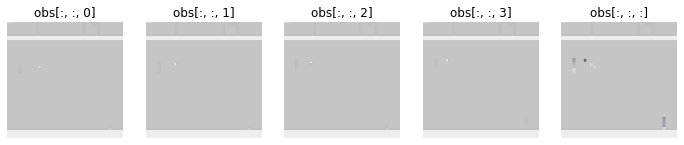

In [17]:
_trajectory, _step = randrange(N_OF_TRAJECTORIES), randrange(N_OF_STEPS)
print(f"trajectory: {_trajectory} (of {N_OF_TRAJECTORIES})")
print(f"step: {_step} (of {N_OF_STEPS})\n")

obs = all_obs[_trajectory, _step] # (84, 84, 4)
# from google.colab.patches import cv2_imshow
# cv2_imshow(obs)
plot_channels(obs)

In [0]:
def mix_channels(obs_image):
    assert obs_image.shape[-1] == 4, "expected an image with 4 channels"
    return np.stack([
        obs_image[:, :, 0:2].mean(axis=-1), 
        obs_image[:, :, 1:3].mean(axis=-1), 
        obs_image[:, :, 2:4].mean(axis=-1), 
    ], axis=-1) # (84, 84, 4) -> (84, 84, 3)

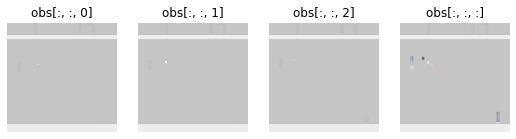

In [19]:
plot_channels(mix_channels(obs))